# Install necessary requirements.

In [1]:
# Install necessary libraries
%pip install numpy h5py spacy pandas tqdm scikit-learn scipy matplotlib ipython --quiet
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Setup for the dataset

The datasets can be downloaded from https://recsys.eb.dk/.

1. Download the eb_nerd dataset locally on your computer.
2. Create the following folder: `RecSysGroup27/ebnerd_data`.
3. Extract the dataset into the `ebnerd_data` folder. \
The folder should contain the following datasets: \
`ebnerd_data/ebnerd_demo` \
`ebnerd_data/ebnerd_large` \
`ebnerd_data/ebnerd_small` \
`ebnerd_data/ebnerd_testset`

Not all datasets are needed. ebnerd_large is only needed if you want to run on the large dataset and ebnerd_testset is only needed if you want to run on the test set. We recommend only using ebnerd_small and ebnerd_demo.

# Training and testing the model

Import packages.

In [1]:
# Import necessary libraries
import torch
from NRMS import NRMS
from NRMSExtended import NRMSExtended
import spacy

# Install danish language model if it is not already installed
try:
    nlp = spacy.load("da_core_news_lg")
    print("spaCy model 'da_core_news_lg' is already installed.")
except:
    print("spaCy model 'da_core_news_lg' not found. Installing...")
    !python -m spacy download da_core_news_lg --quiet
    nlp = spacy.load("da_core_news_lg")

from Training import train, testOnWholeDataset
from Testing import runOnTestSet


spaCy model 'da_core_news_lg' is already installed.


Set the parameters. If you run into memory issues, turn batch_size and validation_batch_size down. You can turn down max_batches if you want to finish the training faster.\
You can change ebnerd_small to ebnerd_demo if you want the data loading to be faster. This may cause the training results to be worse.

In [ ]:
# Check for available device
DEVICE = torch.device("cuda")# if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

# Model parameters
dropout = 0.2
h = 16                              # Number of attention heads in multi-head self-attention

# Train parameters
dataset_name = 'ebnerd_small'   # Name of the dataset used for training and validating
k = 4                           # Number of negative samples to pair with each positive sample
batch_size = 64
weight_decay = 0.0
learning_rate = 1e-3
history_size = 30               # Number of user history entries after truncation or padding
max_title_size = 20             # Number of tokens in an article title after truncation or padding
num_epochs = 100                # Not really used (takes too long to reach number of epochs)
validate_every = 100            # How many train batches between validations
validation_batch_size = 100     # The batch size for validation
n_validation_batches = 100       # How many batches to run for each validation
max_batches = 500              # Turn this down if you want to end the training early

save_model = False #Activate this if you want the best model to best saved during training

cuda


Here the model is created. You can choose whether to use time embeddings or not.
Please restart the kernel if you have already created a model.

In [3]:
with_time_embeddings = True

if with_time_embeddings:
    model = NRMSExtended(nlp, h=h, dropout=dropout).to(DEVICE)
else:
    model = NRMS(nlp, h=h, dropout=dropout).to(DEVICE)

#Uncomment this line if you want to load a model from a saved file.
#model.load_state_dict(torch.load('model_best.pth', map_location=DEVICE))

The next cell runs the training. Here, we train much less than we did for the results shown in the report. Turn up max_batches if you want more training.
Data loading may take up to around 1 minute for ebnerd_small. Use ebnerd_demo as explained above to load faster.

Validation number 2/2
Validation datapoints:  10000


AUC: 100%|████████████████████████████████| 6336/6336 [00:03<00:00, 1982.08it/s]

Validation auc:  0.6586941923617032
Validation loss:  0.027286160945892333
Train auc:  0.6716382575757576
Average train loss:  0.02315664750458014
Average train accuracy:  0.3229166666666667



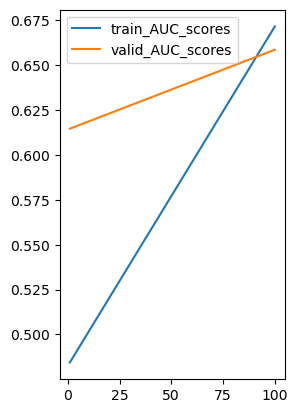

In [4]:
train(
        model=model,
        dataset_name=dataset_name,
        k=k,
        batch_size=batch_size,
        weight_decay=weight_decay,
        learning_rate=learning_rate,
        history_size=history_size,
        max_title_size=max_title_size,
        nlp=nlp,
        save_model=save_model,
        num_epochs=num_epochs,
        validate_every=validate_every,
        validation_batch_size=validation_batch_size,
        n_validation_batches=n_validation_batches,
        max_batches=max_batches,
        with_time_embeddings=with_time_embeddings
    )

Here you can run the model on the whole validation dataset. We recommend running on ebnerd_demo or ebnerd_small. These have about 25000 and 250000 impressions respectively.

In [5]:
with torch.no_grad(): #Test on whole validation set
        final_auc = testOnWholeDataset(model, "ebnerd_demo", "validation", history_size, max_title_size, nlp, batch_size=validation_batch_size, with_time_embeddings=with_time_embeddings)

Time to load data:  2.7557456493377686
Finished: 10000/25356
Finished: 20000/25356


AUC: 100%|██████████████████████████████| 25356/25356 [00:12<00:00, 2006.47it/s]

Final AUC score on whole dataset:  0.6627784112273145


Here you can run on the entire test set and produce an predictions file. This takes a long time so we do not recommend doing this.

In [ ]:
#Uncomment these lines if you want to run on the test set
#with torch.no_grad():
    #runOnTestSet(model, history_size, max_title_size, nlp, batch_size=validation_batch_size, with_time_embeddings=with_time_embeddings)

Time to load data:  2.789428949356079
Finished: 10000/25356
Finished: 20000/25356
Saving file...
